# Machine Learning in Real Estate

### Authors: Robert Conner, Christina Moody

In [1]:
!pip install optuna
!pip install optuna-integration
!pip install scikit-learn
!pip install keras
!pip install optuna
!pip install joblib
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00


In [4]:
#import required libs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv1D, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
import optuna
import joblib
import os

#To hide future warnings
    #Deprecation warning pertain to future possible errors as the current code may be deprecated (eliminated)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
#style options

%matplotlib inline
#if you want graphs to automatically without plt.show
pd.set_option('display.max_columns',500)

sns.set_style('whitegrid')

In [5]:
#Import datasets
df = pd.read_csv('Quarry Bay.csv', index_col = 0, header=0)
#DOES set the first column to the index
# and the top row as the headers
#change index to a column
df.reset_index(drop=True,inplace=True)
#display .info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24936 entries, 0 to 24935
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RP      24936 non-null  float64
 1   GFA     24936 non-null  int64  
 2   AGE     24936 non-null  float64
 3   ZZ      24936 non-null  float64
 4   FL      24936 non-null  int64  
 5   FR      24936 non-null  int64  
 6   ROOF    24936 non-null  int64  
 7   CP      24936 non-null  int64  
 8   MTR     24936 non-null  int64  
 9   E       24936 non-null  int64  
 10  S       24936 non-null  int64  
 11  W       24936 non-null  int64  
 12  N       24936 non-null  int64  
 13  NE      24936 non-null  int64  
 14  SE      24936 non-null  int64  
 15  SW      24936 non-null  int64  
 16  NW      24936 non-null  int64  
dtypes: float64(3), int64(14)
memory usage: 3.2 MB


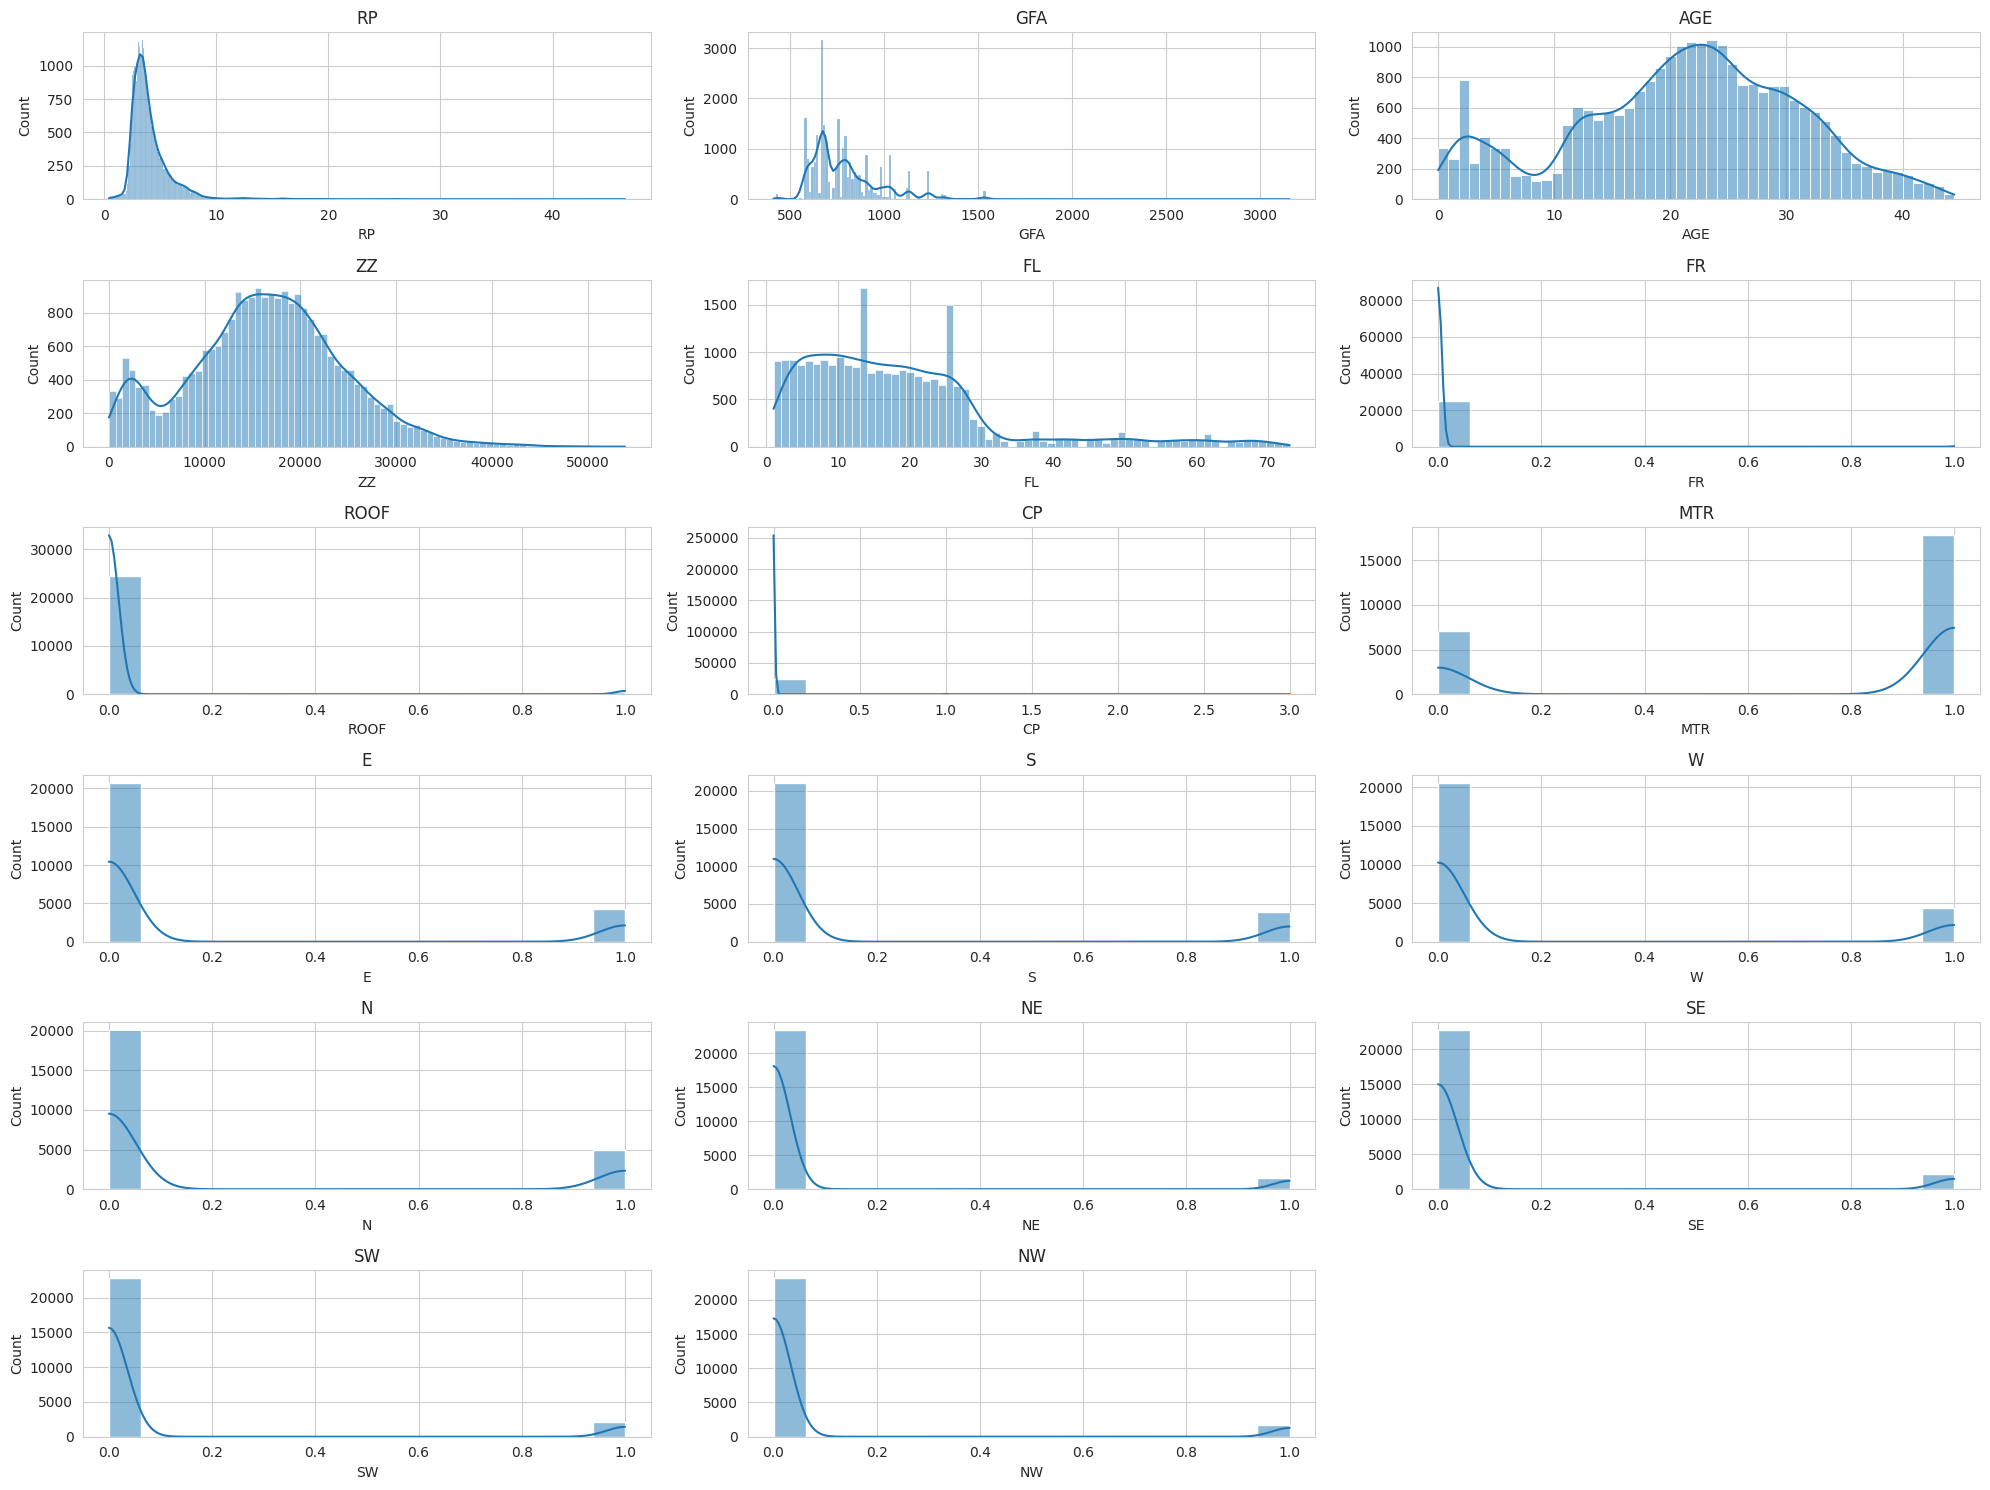

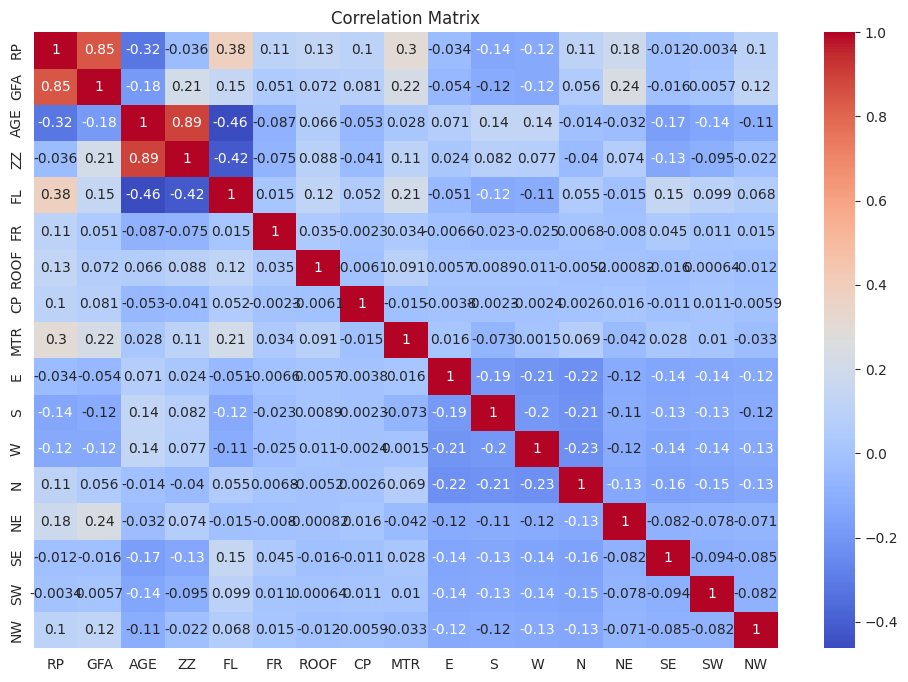

In [6]:
# Histograms for each variable as done in the original paper
plt.figure(figsize=(20, 15))
num_vars = len(df.columns)
for i, column in enumerate(df.columns):
    plt.subplot((num_vars // 3) + 1, 3, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(column)
plt.tight_layout()
# Save the plot as an image
plt.savefig('hist.png', bbox_inches='tight')
plt.show()


# Correlation matrix heatmap as done in the original paper
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
# Save the plot as an image
plt.savefig('cm.png', bbox_inches='tight')
plt.show()

In [7]:
# Define X and y
X = df.drop(['RP','NW'], axis=1)
y = df['RP']

In [8]:
# Function for Kernel Ridge Regression with separate train, validation, and test sets
def kernel_ridge_regression(X, y, n_trials=100):
    # Split the data into training, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.22, random_state=42)

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data only
    X_train_scaled = scaler.fit_transform(X_train)

    # Apply the scaling to the validation data
    X_val_scaled = scaler.transform(X_val)

    X_train_val_scaled = scaler.transform(X_train_val)
    X_test_scaled = scaler.transform(X_test)

    mse_values = []  # List to store MSE values

    def objective(trial):
        # Hyperparameters to be tuned by Optuna
        alpha = trial.suggest_loguniform('alpha', 1e-4, 1e-2)  # Narrowed from 10 to 1
        kernel = trial.suggest_categorical('kernel', ['poly', 'rbf'])  # Removed 'linear'
        gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-3)  # Narrowed from 1e-1 to 1e-2


        # Model definition
        model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma)

        # Model training with scaled data
        model.fit(X_train_scaled, y_train)

        # Validation for hyperparameters
        val_pred = model.predict(X_val_scaled)
        mse = mean_squared_error(y_val, val_pred)  # Calculate MSE
        r2 = r2_score(y_val, val_pred)  # Calculate R^2 for monitoring purposes

        mse_values.append(mse)  # Append the MSE value to the list

        return mse  # Optimize for MSE

    # Create a study object and optimize the objective function
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)

    # Create a line plot of trials vs MSE
    plt.figure(figsize=(10, 6))
    plt.plot(mse_values, label='MSE per Trial')
    plt.xlabel('Trial Number')
    plt.ylabel('MSE')
    plt.title('Optuna Optimization: Trial vs MSE')
    plt.legend()
    plt.show()

    # Print the hyperparameters and both MSE and R^2 for the best trial
    best_trial = study.best_trial
    print(f"Best Trial {best_trial.number}, Hyperparameters: {best_trial.params}, MSE: {best_trial.value}")

    return study.best_params, best_trial, (X_train_val_scaled, y_train_val), (X_test_scaled, y_test)


This function is for performing Kernel Ridge Regression. The function kernel_ridge_regression takes a dataset (X and y) and the number of trials (n_trials) for hyperparameter optimization.

The data is split into train/validation/test splits (~ 70%/~20%/10%). A StandardScaler is used to normalize the training data, and the same scaling parameters are applied to the validation and test data to maintain consistency.

Most of the function revolves around hyperparameter optimization using Optuna, a hyperparameter optimization framework. It tunes three key hyperparameters of the Kernel Ridge Regression model: alpha (regularization strength), kernel (type of kernel), and gamma (kernel coefficient). These hyperparameters are varied within specified ranges, aiming to minimize the Mean Squared Error (MSE) on the validation set. The function was run multiple times and the initial values were changed based on the best performing hyperparameters for each run.

Each trial's MSE is recorded, and a line plot is generated to visualize the MSE's progression across trials. This visual aid helps in understanding how the model's performance evolves with different hyperparameter combinations.

After completing the specified number of trials, the function identifies the best trial based on the lowest MSE. It then prints the hyperparameters of this trial, along with its MSE, providing insights into the most effective settings for the Kernel Ridge Regression model on the given dataset.

Finally, the function returns the best hyperparameters, the best trial's details, and the scaled training/validation and test datasets. This comprehensive output enables further analysis and application of the optimized model on the test data, or potentially in other related tasks.

In [9]:
# Function for Support Vector Regression with separate train, validation, and test sets
def support_vector_regression(X, y, n_trials=100):
    # Split the data into training, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.22, random_state=42)

    mse_values = []

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data only
    X_train_scaled = scaler.fit_transform(X_train)

    # Apply the scaling to the validation data
    X_val_scaled = scaler.transform(X_val)

    X_train_val_scaled = scaler.transform(X_train_val)
    X_test_scaled = scaler.transform(X_test)

    def objective(trial):
        # Hyperparameters to be tuned by Optuna
        C = trial.suggest_loguniform('C', 0.1, 10)  # Narrowed around 0.66
        epsilon = trial.suggest_loguniform('epsilon', 0.1, 1)  # Narrowed around 0.77
        kernel = trial.suggest_categorical('kernel', ['poly', 'rbf'])  # Focusing on 'poly' and 'rbf''

        # Model definition
        model = SVR(C=C, epsilon=epsilon, kernel=kernel)

        # Model training with scaled data
        model.fit(X_train_scaled, y_train)

        # Validation for hyperparameters
        val_pred = model.predict(X_val_scaled)
        mse = mean_squared_error(y_val, val_pred)  # Calculate MSE
        r2 = r2_score(y_val, val_pred)  # Calculate R^2 for monitoring purposes
        trial.set_user_attr('r2_score', r2)  # Store the R^2 score as a user attribute

        mse_values.append(mse)  # Append the MSE value to the list

        return mse  # Optimize for MSE

    # Create a study object and optimize the objective function
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)

    # Create a line plot of trials vs MSE
    plt.figure(figsize=(10, 6))
    plt.plot(mse_values, label='MSE per Trial')
    plt.xlabel('Trial Number')
    plt.ylabel('MSE')
    plt.title('Optuna Optimization: Trial vs MSE')
    plt.legend()
    plt.show()

    # Print the hyperparameters and both MSE and R^2 for the best trial
    best_trial = study.best_trial
    print(f"Best Trial {best_trial.number}, Hyperparameters: {best_trial.params}, MSE: {best_trial.value}")

    return study.best_params, best_trial, (X_train_val_scaled, y_train_val), (X_test_scaled, y_test)



This function follows the same framework as the k-NN function, except it applies the Support Vector Regression (SVR) model. The key parameters tuned using Optuna include the regularization parameter (C), epsilon (margin of tolerance), and the kernel type. It also employs a StandardScaler for data normalization and evaluates model performance using Mean Squared Error (MSE) and R-squared (R²) on the validation set. The function concludes by returning the optimized hyperparameters, the best trial's details, and the scaled datasets.

In [10]:
# Function for MLP Regression with separate train, validation, and test sets
def mlp_regression(X, y, n_trials=50):
    # Split the data into training, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.22, random_state=42)

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data only
    X_train_scaled = scaler.fit_transform(X_train)

    mse_values = []

    # Apply the scaling to the validation and test data
    X_val_scaled = scaler.transform(X_val)
    X_train_val_scaled = scaler.transform(X_train_val)
    X_test_scaled = scaler.transform(X_test)

    def objective(trial):
        # Hyperparameters to be tuned by Optuna (narrowed from previous runs)
        hidden_layer_sizes = (
            trial.suggest_int('n_units_l0', 95, 120),
            trial.suggest_int('n_units_l1', 50, 70),
            trial.suggest_int('n_units_l2', 25, 45)
        )
        activation = 'relu'  # Prioritizing 'relu'
        solver = trial.suggest_categorical('solver', ['sgd'])  # 'sgd' showed good performance
        alpha = trial.suggest_loguniform('alpha', 0.001, 0.005)  # Further narrowed range around the best values
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])


        # Model definition
        model = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            alpha=alpha,
            learning_rate=learning_rate,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10,
            max_iter=300
        )

        try:
            # Model training
            model.fit(X_train_scaled, y_train)

            # Validation for hyperparameters
            val_pred = model.predict(X_val_scaled)
            mse = mean_squared_error(y_val, val_pred)
            r2 = r2_score(y_val, val_pred)

        except Exception as e:
            print(f"An error occurred during training: {e}")
            mse = float('inf')  # Assign a high MSE value to signify failure
            r2 = -float('inf')  # Assign a very low R^2 value to signify failure

        mse_values.append(mse)

        return mse  # Optimize for MSE

    # Create a study object and optimize the objective function
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)

    # Create a line plot of trials vs MSE
    plt.figure(figsize=(10, 6))
    plt.plot(mse_values, label='MSE per Trial')
    plt.xlabel('Trial Number')
    plt.ylabel('MSE')
    plt.title('Optuna Optimization: Trial vs MSE')
    plt.legend()
    plt.show()

    # Print the hyperparameters and both MSE and R^2 for the best trial
    best_trial = study.best_trial
    print(f"Best Trial {best_trial.number}, Hyperparameters: {best_trial.params}, MSE: {best_trial.value}")

    # Return the best hyperparameters, and the scaled train-val and test sets
    return study.best_params, best_trial, (X_train_val_scaled, y_train_val), (X_test_scaled, y_test)

This function is designed for Multi-Layer Perceptron (MLP) regression and it also follows the same framework as the previous functions. It focuses on optimizing parameters like hidden_layer_sizes, solver, alpha, and learning_rate. Exception handling is incorporated to manage any training failures (since training could take a long time), assigning extreme MSE values as indicators. The evaluation criteria include MSE and R². The output includes the best hyperparameters, details of the optimal trial, and the scaled datasets for further application.

In [11]:
# Save the best models
def save_model(model, model_name, directory="models"):
    if not os.path.exists(directory):
        os.makedirs(directory)

    # List all files in the directory
    files = os.listdir(directory)

    # Count how many files already have the 'best_model_' pattern with the specific model_name
    pattern = f"best_model_{model_name}_"
    count = sum(1 for filename in files if filename.startswith(pattern))

    # Define the model filename
    model_filename = f"{pattern}{count}.joblib"
    model_path = os.path.join(directory, model_filename)

    # Save the model using joblib
    joblib.dump(model, model_path)

    print(f"Model saved as {model_path}")
    return model_path

In this function we save the best models for each of the model types. The function is made so that if I ran all the functions multiple times, the saved files would have dynamic names.

In [12]:
# Calculate MAPE function
def calculate_mape(actual, pred):
    total_error = 0
    for actualv, predicted in zip(actual, pred):
        if actualv != 0:
            total_error += abs((actualv - predicted) / actualv)
    mape = (total_error / len(actual)) * 100
    return mape


In [13]:
# Evaluation function for Kernel Ridge Regression
def evaluate_kernel_ridge_regression(best_params, best_trial, train_val_data, test_data):
    X_train_val, y_train_val = train_val_data
    X_test, y_test = test_data

    # Retrain the model with the best hyperparameters on the combined training and validation set
    model = KernelRidge(**best_params)
    model.fit(X_train_val, y_train_val)

    # Predict on the test set
    test_pred = model.predict(X_test)

    # Calculate both the metric scores
    test_mse = mean_squared_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_mape = calculate_mape(y_test, test_pred)
    test_rmse = sqrt(test_mse)

    # Plot the model diagnostics
    plot_model_diagnostics(y_test, test_pred, 'Kernel Ridge Regression')

    model_name = "KRR"
    save_model_path = save_model(model, model_name)

    # Return all metrics
    return test_mse, test_r2, test_mape, test_rmse

The 'evaluate_kernel_ridge_regression' function is called directly following the training function. This evaluation is conducted using the best hyperparameters determined from previous optimization efforts. The function accepts four parameters: best_params, best_trial, train_val_data, and test_data.

Initially, the function retrains the Kernel Ridge Regression model using the best hyperparameters (best_params) on a dataset that combines both training and validation data (train_val_data). This step ensures that the model leverages the full potential of the optimized parameters for enhanced performance. Following the retraining, the model is used to make predictions on the test dataset (test_data).

The evaluation lies in the computation of two key metrics, as done in the research paper: the Mean Squared Error (MSE) and the R-squared (R²) score, based on the model's predictions on the test set. The function includes a procedure for visualizing model diagnostics, through plots that compare actual vs. predicted values or assess residual patterns. The trained model is saved for future use, utilizing the designated save_model function, and is identified with the name "KRR" (Kernel Ridge Regression).

Finally, the function concludes by returning the calculated MSE and R² scores from the test dataset.

In [14]:
# Evaluation function for Support Vector Regression
def evaluate_svr(best_params, best_trial, train_val_data, test_data):
    X_train_val, y_train_val = train_val_data
    X_test, y_test = test_data

    # Retrain the model with the best hyperparameters on the combined training and validation set
    best_model = SVR(**best_params)
    best_model.fit(X_train_val, y_train_val)

    # Predict on the test set for scoring
    test_pred = best_model.predict(X_test)

    # Calculate both the metric scores
    test_mse = mean_squared_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_mape = calculate_mape(y_test, test_pred)
    test_rmse = sqrt(test_mse)

    # Get the number of support vectors
    n_support_vectors = best_model.support_.size

    # Plot the model diagnostics including the number of support vectors
    plot_model_diagnostics(y_test, test_pred, 'SVR', additional_info={'n_support_vectors': n_support_vectors})

    model_name = "SVR"
    save_model_path = save_model(best_model, model_name)

    # Return all metrics
    return test_mse, test_r2, test_mape, test_rmse

The evaluate_svr function performs essentially the same functions as the evaluate_kernel_ridge_regression function, but for a Support Vector Regression (SVR) model. It evaluates the SVR model using the best hyperparameters obtained from prior optimization, retraining the model with the combined training and validation data, making predictions on the test set, and calculating key performance metrics (Mean Squared Error and R-squared score).

Additionally, it includes a unique step for the SVR model: retrieving the number of support vectors used in the model, which is an important characteristic of SVR models. This information, along with the standard evaluation metrics, is included in the model diagnostics visualization. The function also saves the trained model for future use by saving it, and it returns the calculated MSE and R² scores for the test dataset.

In [15]:
# Evaluation function for MLP
def evaluate_mlp(best_params, best_trial, train_val_data, test_data, additional_info=None):
    # Modify the best_params to create a tuple for hidden_layer_sizes
    hidden_layer_sizes = tuple(best_params.pop(f'n_units_l{i}') for i in range(3))
    # Update the best_params with the correct hidden_layer_sizes
    best_params['hidden_layer_sizes'] = hidden_layer_sizes

    X_train_val, y_train_val = train_val_data
    X_test, y_test = test_data

    try:
        # Retrain the model with the best hyperparameters on the combined training and validation set
        best_model = MLPRegressor(**best_params)
        best_model.fit(X_train_val, y_train_val)

        # Predict on the test set for scoring
        test_pred = best_model.predict(X_test)

        # Calculate both the metric scores
        test_mse = mean_squared_error(y_test, test_pred)
        test_r2 = r2_score(y_test, test_pred)
        test_mape = calculate_mape(y_test, test_pred)
        test_rmse = sqrt(test_mse)

        # Plot the model diagnostics
        plot_model_diagnostics(y_test, test_pred, 'MLP Regression')

        model_name = "MLP"
        save_model_path = save_model(best_model, model_name)

    except Exception as e:
        print(f"An error occurred during evaluation: {e}")
        test_mse = float('inf')  # Assign a high MSE value to signify failure
        test_r2 = -float('inf')  # Assign a very low R^2 value to signify failure

    # Return all metrics
    return test_mse, test_r2, test_mape, test_rmse

The evaluate_mlp function performs the same core functions as the evaluate_svr function, but specifically for a Multi-Layer Perceptron (MLP) model. It involves retraining the MLP model with the best hyperparameters, making predictions on the test dataset, calculating the Mean Squared Error (MSE) and R-squared (R²) scores, visualizing model diagnostics, saving the trained model, and returning the test metrics.

There is a unique aspect in the evaluate_mlp function related to handling the hidden_layer_sizes parameter. Before retraining the model, it constructs the hidden_layer_sizes tuple from the best parameters, ensuring the MLP model is configured correctly. Additionally, it includes an exception handling mechanism to manage any errors that might occur during model evaluation, assigning extreme values to MSE and R² in case of failure. This approach enhances the robustness of the evaluation process, ensuring that the function gracefully handles any unforeseen issues during model retraining or evaluation. Primarily, it allows the process to finish without the need to re-run it constantly if an issue arises during training (such as non-convergence).

In [16]:
# Function to plot model evaluation diagnostics
def plot_model_diagnostics(y_true, y_pred, model_name, additional_info=None):
    # Common plots for all models
    plt.figure(figsize=(18, 6))

    # Subplot 1: Actual vs Predicted scatter plot
    plt.subplot(1, 4, 1)
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)  # Diagonal line for reference
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {model_name}')

    # Subplot 2: Residuals plot
    plt.subplot(1, 4, 2)
    residuals = y_true - y_pred
    sns.scatterplot(x=y_pred, y=residuals)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='k', linestyles='--', lw=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot - {model_name}')

    # Subplot 3: Histogram of residuals
    plt.subplot(1, 4, 3)
    sns.histplot(residuals, bins=30, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'Histogram of Residuals - {model_name}')

    # Model-specific plots
    if model_name == 'SVR' and additional_info:
        # Subplot 4: Support Vectors
        plt.subplot(1, 4, 4)
        sns.barplot(x=['Support Vectors'], y=[additional_info['n_support_vectors']])
        plt.ylabel('Number of Support Vectors')
        plt.title(f'Support Vectors - {model_name}')

    plt.tight_layout()
    plt.show()

The plot_model_diagnostics function is designed to visualize various diagnostic plots for evaluating regression models. It accepts the actual values (y_true), predicted values (y_pred), the model's name (model_name), and an optional dictionary for additional information, which contains additional information needed for the model specific plot for SVR.

The function creates a series of subplots in a single figure, providing a comprehensive visual assessment of the model's performance:

Actual vs. Predicted Scatter Plot: The first subplot illustrates the relationship between the actual and predicted values. A diagonal reference line is included to indicate perfect predictions.

Residuals Plot: The second subplot shows the residuals (the difference between actual and predicted values) plotted against the predicted values. A horizontal line at zero is included to indicate where residuals would be if the model's predictions were perfect.

Histogram of Residuals: The third subplot is a histogram (with kernel density estimation) of the residuals. This plot is useful for checking the normality of the residuals, which is an assumption in many regression models.

For model-specific diagnostics:

SVR (Support Vector Regression): If the model is SVR and additional information about the number of support vectors is provided, a bar plot showing the number of support vectors is displayed. This number helps to inform us about the complexity of the model.

[I 2023-11-16 15:22:48,589] A new study created in memory with name: no-name-3e472dbe-6086-4955-9c4e-952297a3d9a6
[I 2023-11-16 15:24:32,060] Trial 1 finished with value: 0.36358394988446574 and parameters: {'alpha': 0.0004915021377946274, 'kernel': 'rbf', 'gamma': 0.0009880289756849946}. Best is trial 1 with value: 0.36358394988446574.
[I 2023-11-16 15:25:50,620] Trial 0 finished with value: 0.45687040993320854 and parameters: {'alpha': 0.0009377404322490076, 'kernel': 'poly', 'gamma': 0.00010253646661382487}. Best is trial 1 with value: 0.36358394988446574.
[I 2023-11-16 15:27:21,137] Trial 2 finished with value: 0.46877467304950443 and parameters: {'alpha': 0.0031483499531241637, 'kernel': 'rbf', 'gamma': 0.00020031891647620648}. Best is trial 1 with value: 0.36358394988446574.
[I 2023-11-16 15:28:37,999] Trial 3 finished with value: 0.41528594222928267 and parameters: {'alpha': 0.0021151609261164444, 'kernel': 'poly', 'gamma': 0.00033823793521857567}. Best is trial 1 with value: 0.

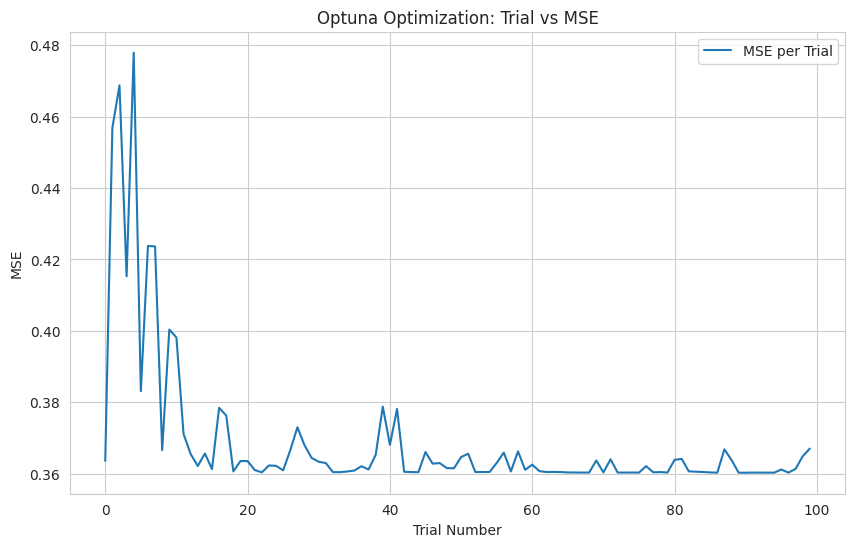

Best Trial 90, Hyperparameters: {'alpha': 0.00019918039984299912, 'kernel': 'rbf', 'gamma': 0.0009959647512541206}, MSE: 0.3602673666612439
CPU times: user 3h 41min 10s, sys: 19min 30s, total: 4h 40s
Wall time: 2h 27min 55s


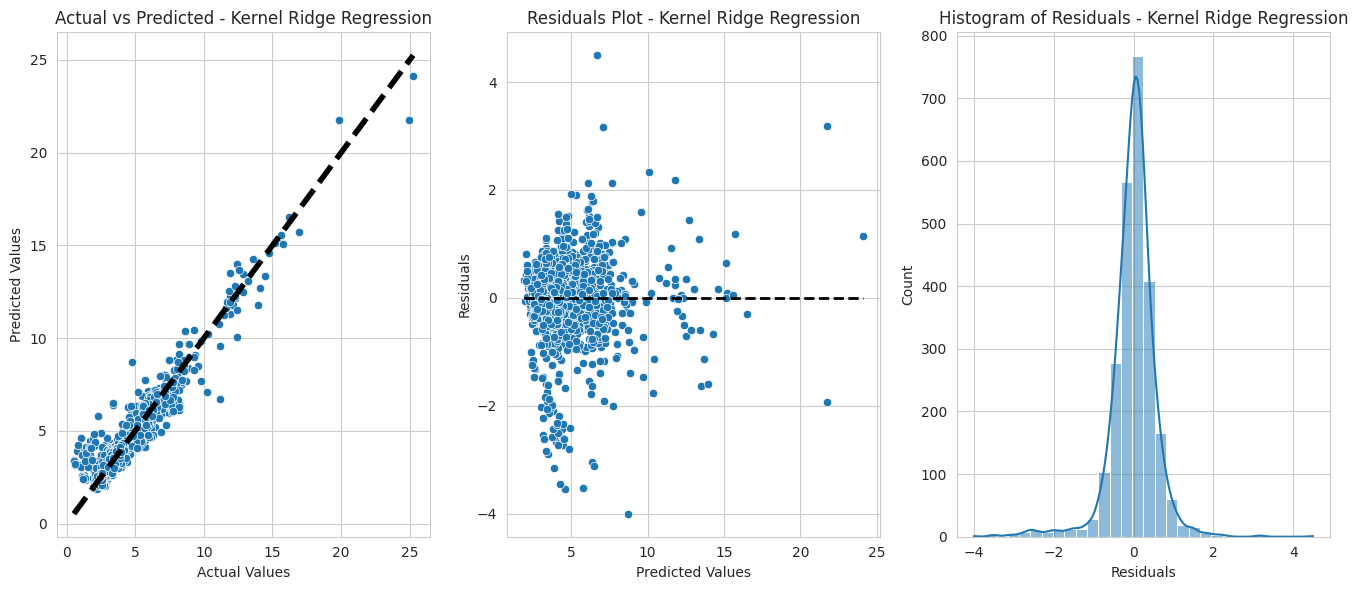

Model saved as models/best_model_KRR_0.joblib
CPU times: user 4min 10s, sys: 11.2 s, total: 4min 21s
Wall time: 2min 51s


In [17]:
#Trial 3 (Uses the most narrow search parameters and displays final models)

# Run Kernel Ridge Regression Hyperparameter Tuning
%time krr_best_params, krr_best_trial, krr_train_val_data, krr_test_data = kernel_ridge_regression(X, y)

# Evaluate Kernel Ridge Regression with the best parameters
%time krr_test_mse, krr_test_r2, krr_test_mape, krr_test_rmse = evaluate_kernel_ridge_regression(krr_best_params, krr_best_trial, krr_train_val_data, krr_test_data)


[I 2023-11-16 17:53:35,430] A new study created in memory with name: no-name-0050c49d-b7f4-47ff-a386-960c43a325c8
[I 2023-11-16 17:53:46,675] Trial 0 finished with value: 0.6674924217378324 and parameters: {'C': 8.591506765714131, 'epsilon': 0.5765465736422691, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6674924217378324.
[I 2023-11-16 17:54:01,779] Trial 1 finished with value: 0.7687013927710205 and parameters: {'C': 0.9489803201052373, 'epsilon': 0.4010826767242219, 'kernel': 'poly'}. Best is trial 0 with value: 0.6674924217378324.
[I 2023-11-16 17:54:20,677] Trial 2 finished with value: 0.6652547835326202 and parameters: {'C': 9.13267971815409, 'epsilon': 0.205951162771131, 'kernel': 'rbf'}. Best is trial 2 with value: 0.6652547835326202.
[I 2023-11-16 17:54:34,796] Trial 3 finished with value: 0.664517231561632 and parameters: {'C': 9.46258833037978, 'epsilon': 0.22283280137943712, 'kernel': 'rbf'}. Best is trial 3 with value: 0.664517231561632.
[I 2023-11-16 17:54:44,212] Tria

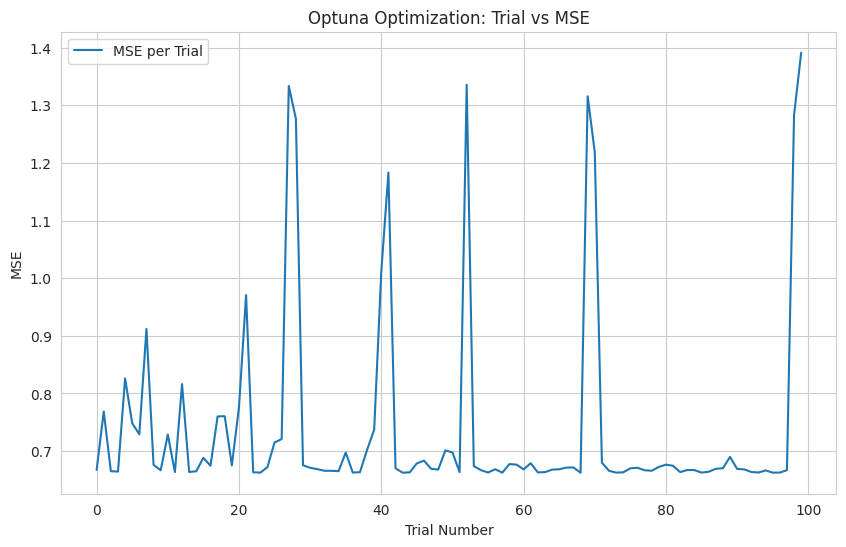

Best Trial 68, Hyperparameters: {'C': 9.98886876008175, 'epsilon': 0.30200512856245704, 'kernel': 'rbf'}, MSE: 0.6625810221205164
CPU times: user 45min 45s, sys: 17.9 s, total: 46min 3s
Wall time: 28min 21s


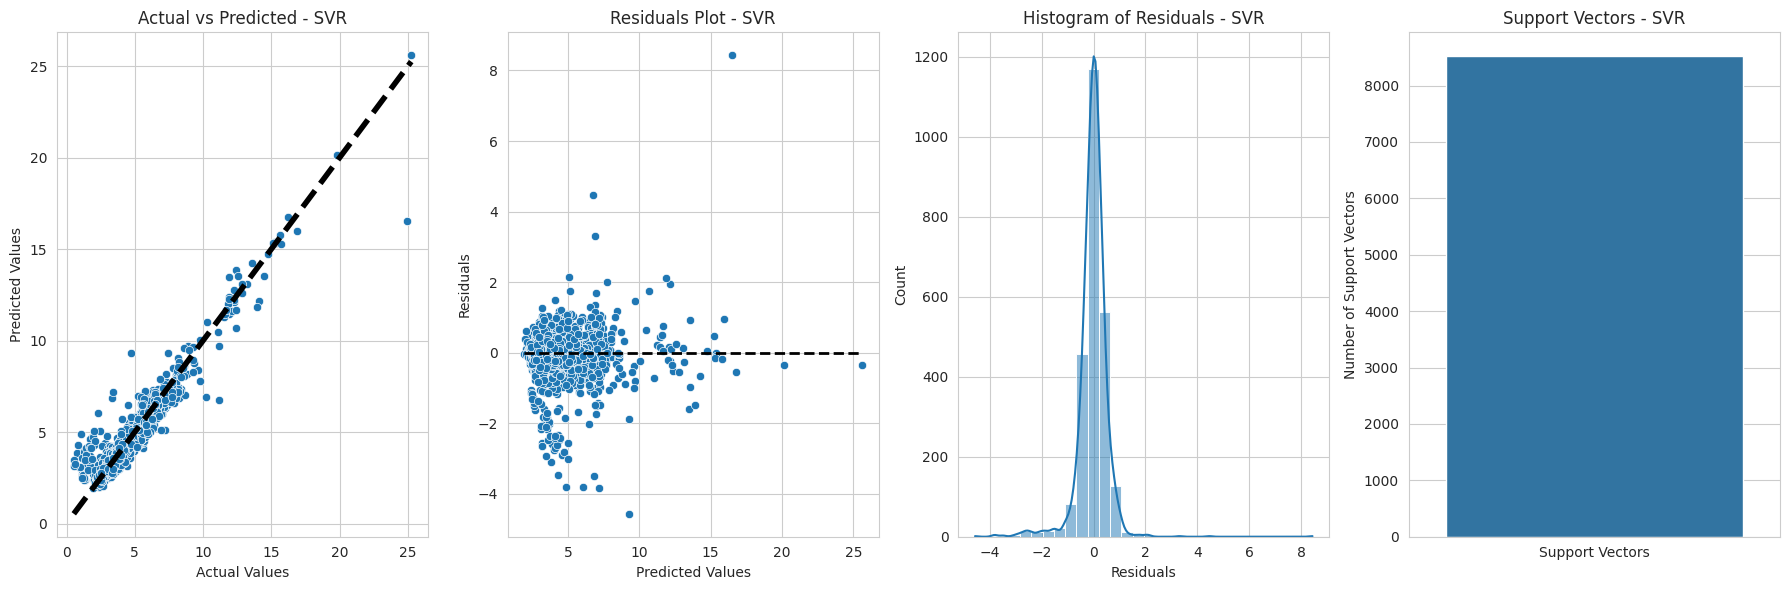

Model saved as models/best_model_SVR_0.joblib
CPU times: user 21.1 s, sys: 494 ms, total: 21.6 s
Wall time: 21.2 s


In [18]:
# Run Support Vector Regression Hyperparameter Tuning
%time svr_best_params, svr_best_trial, svr_train_val_data, svr_test_data = support_vector_regression(X, y)

# Evaluate Support Vector Regression with the best parameters
%time svr_test_mse, svr_test_r2, svr_test_mape, svr_test_rmse = evaluate_svr(svr_best_params, svr_best_trial, svr_train_val_data, svr_test_data)


[I 2023-11-16 18:22:18,185] A new study created in memory with name: no-name-9a8e568e-4b08-424c-a653-2c7a5b626f53
[I 2023-11-16 18:23:46,581] Trial 1 finished with value: 0.34293268910268937 and parameters: {'n_units_l0': 105, 'n_units_l1': 60, 'n_units_l2': 35, 'solver': 'sgd', 'alpha': 0.0013874001652465129, 'learning_rate': 'constant'}. Best is trial 1 with value: 0.34293268910268937.
[I 2023-11-16 18:24:20,517] Trial 0 finished with value: 0.3480520298818653 and parameters: {'n_units_l0': 109, 'n_units_l1': 51, 'n_units_l2': 41, 'solver': 'sgd', 'alpha': 0.0014860792200403947, 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.34293268910268937.
[I 2023-11-16 18:25:36,270] Trial 2 finished with value: 0.33933101015565886 and parameters: {'n_units_l0': 108, 'n_units_l1': 59, 'n_units_l2': 32, 'solver': 'sgd', 'alpha': 0.0026500506369378524, 'learning_rate': 'constant'}. Best is trial 2 with value: 0.33933101015565886.
[I 2023-11-16 18:26:02,663] Trial 3 finished with value:

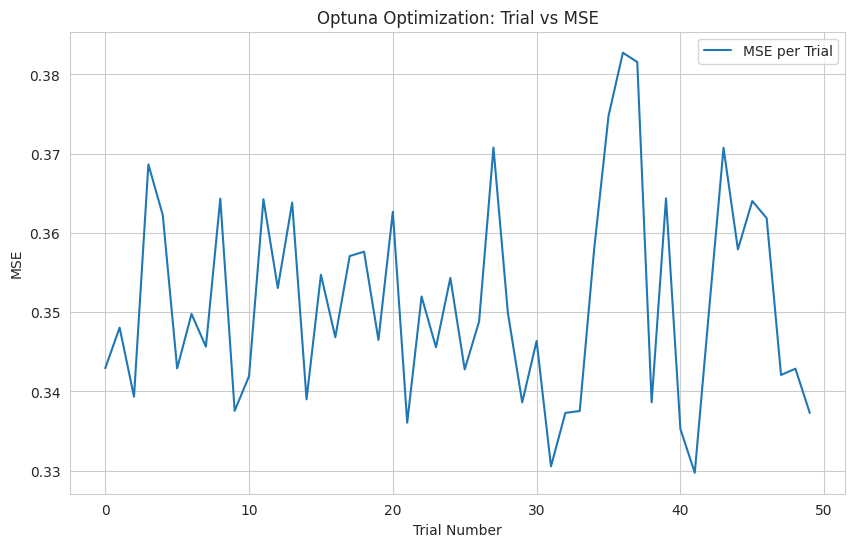

Best Trial 41, Hyperparameters: {'n_units_l0': 111, 'n_units_l1': 61, 'n_units_l2': 39, 'solver': 'sgd', 'alpha': 0.003638217516544642, 'learning_rate': 'adaptive'}, MSE: 0.3297413099593494
CPU times: user 54min 17s, sys: 34min 49s, total: 1h 29min 7s
Wall time: 54min 17s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


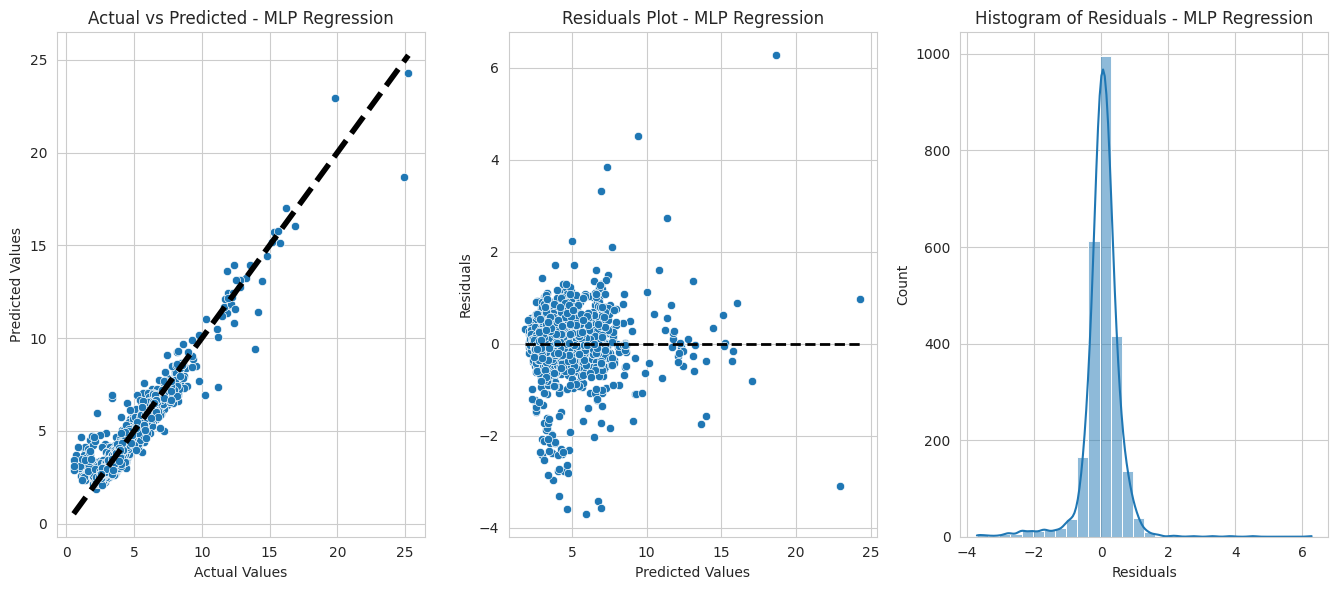

Model saved as models/best_model_MLP_0.joblib
CPU times: user 1min 17s, sys: 42.7 s, total: 2min
Wall time: 1min 12s


In [19]:
# Run MLP Regression Hyperparameter Tuning
%time mlp_best_params, mlp_best_trial, mlp_train_val_data, mlp_test_data = mlp_regression(X, y)

# Evaluate MLP Regression with the best parameters
%time mlp_test_mse, mlp_test_r2, mlp_test_mape, mlp_test_rmse = evaluate_mlp(mlp_best_params, mlp_best_trial, mlp_train_val_data, mlp_test_data)

In [20]:
# Create a dictionary with the results
results = {
    "Model": ["Kernel Ridge Regression", "Support Vector Regression", "MLP Regression"],
    "Test MSE": [krr_test_mse, svr_test_mse, mlp_test_mse],
    "Test R²": [krr_test_r2, svr_test_r2, mlp_test_r2],
    "Test MAPE": [krr_test_mape, svr_test_mape, mlp_test_mape],
    "Test RMSE": [krr_test_rmse, svr_test_rmse, mlp_test_rmse]
}

# Dictionary of results from the original paper
original_study_results = {
    "Model": ["ET (Orig. Study)", "KNN (Orig. Study)", "Random Forest (Orig. Study)", "Ordinary Least Squares (Orig. Study)"],
    "Test R²": [0.91164, 0.89530, 0.91928, 0.81400],
    "Test MSE": [0.30561, 0.36211, 0.27918, 0.63890],
    "Test RMSE": [0.55282, 0.60176, 0.52837, 0.79931],
    "Test MAPE": [9.04653, 10.39521, 8.88930, 14.54268]
}

# Convert the dictionaries into DataFrames
results_df = pd.DataFrame(results)
original_study_results_df = pd.DataFrame(original_study_results)

# Combine the DataFrames
combined_df = pd.concat([results_df, original_study_results_df], ignore_index=True)

# Set the 'Model' column as the index
combined_df.set_index('Model', inplace=True)

# Display the DataFrame
display(combined_df)


,Test MSE,Test R²,Test MAPE,Test RMSE
Model,,,,
Kernel Ridge Regression,0.333114,0.909128,11.566388,0.577160
Support Vector Regression,0.328023,0.910517,11.009784,0.572733
MLP Regression,0.308698,0.915789,10.606829,0.555606
ET (Orig. Study),0.305610,0.911640,9.046530,0.552820
KNN (Orig. Study),0.362110,0.895300,10.395210,0.601760
Random Forest (Orig. Study),0.279180,0.919280,8.889300,0.528370
Ordinary Least Squares (Orig. Study),0.638900,0.814000,14.542680,0.799310
